# Testing time features
## I made features that track recent grant history for a given nationality, and recent grant history for a given judge. here, I first run the baseline model (with only judge, nta date, nationality), then a model with master_app features added, then a model with master_app and the new grant history features added.

In [16]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#notes: 
#this has master_app data--eventually put sched data in here as well
#added 3 features for nat grant rate history last year (grant rate, num dec, dummy for nan), and 3 for tracid grant rate
#added an "interaction" term, grant_rate x num_dec, to scale rates by how "confident" they are. this helped, so leaving it in
#baseline model is doing worse here than in baseline model script. why?


## Creating Test/Train Sets

In [2]:
file = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app.csv')
#file = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse.csv') #version w time features
train_cases = pd.read_csv('/home/emilyboeke/train_cases_any_asylum.csv', header=None).values

In [3]:
train_cases = train_cases.reshape(train_cases.shape[0])
train = file[file.idncase.isin(train_cases)]



In [4]:
train.head(10)

,idncase,idnproceeding,idnProceedingAppln,numAppsPerProc,dec,nat,case_type,c_asy_type,base_city_code,hearing_loc_code,osc_date,comp_date,attorney_flag,tracid,numProcPerCase
0,2046931.0,3200059.0,803710,4.0,DENY,CH,RMV,def,CHI,CHD,2003-09-09,2004-02-20,1.0,32.0,1
1,2046932.0,3371117.0,2819106,3.0,DENY,CH,RMV,def,NYC,NYC,2003-09-09,2005-05-13,1.0,148.0,1
2,2046933.0,3200063.0,3390354,3.0,DENY,CH,RMV,def,CLE,CEL,2003-09-16,2007-08-15,1.0,3.0,1
3,2046934.0,3200066.0,803711,2.0,DENY,CM,RMV,def,CHI,CHD,2003-09-24,2004-01-06,1.0,31.0,1
4,2046935.0,3200067.0,1681269,2.0,DENY,CH,AOC,def,CHI,CHD,2003-09-08,2004-01-30,1.0,32.0,1
6,2046938.0,3200072.0,803713,3.0,DENY,AL,RMV,def,CHI,CHD,2003-10-01,2003-11-20,1.0,113.0,1
7,2046939.0,3200073.0,803714,3.0,DENY,AL,RMV,def,CHI,CHD,2003-10-01,2003-11-20,1.0,113.0,1
8,2046941.0,3200077.0,803718,3.0,DENY,CH,RMV,def,CHI,CHD,2003-10-01,2004-03-16,1.0,27.0,1
9,2046942.0,3200078.0,1681270,2.0,GRANT,ET,AOC,def,CHI,CHD,2003-09-22,2003-11-21,1.0,26.0,1
10,2046944.0,4579436.0,3916760,3.0,GRANT,CH,RMV,def,NYC,NYC,2003-10-06,2010-03-12,1.0,147.0,1


In [3]:
class Cleaning_Baseline(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[['dec','nat','osc_date','tracid']]
        X.loc[(X["dec"] == 'DENY'),'dec'] = 0
        X.loc[(X["dec"] == 'GRANT'),'dec'] = 1
        X['osc_date'] = pd.to_datetime(X['osc_date'],infer_datetime_format = True)
        startdate = np.datetime64('1984-01-01')
        X['osc_date_in_days'] = X['osc_date'].apply(lambda x: (x - startdate).days)
        X = X.drop(columns=['osc_date'], axis=1)
        return X
    

In [6]:
clean = Cleaning_Baseline()
train_data = clean.transform(train)
train_data.head()

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,dec,nat,tracid,osc_date_in_days
0,0,CH,32.0,7191
1,0,CH,148.0,7191
2,0,CH,3.0,7198
3,0,CM,31.0,7206
4,0,CH,32.0,7190


In [10]:
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

## Generating Pipeline

In [4]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [5]:
#EB added get_orig_classes, which allows us to see the original variable type of the feature, i.e. nat
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        return self.orig_classes.tolist()

In [6]:
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder()),
]) 

full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

In [11]:
X_train_tr= full_pipeline.fit_transform(X_train)

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Hyperparameter Grid Search On Logistic Regression--test baseline model

In [12]:
param_grid = { 'C': [.000001,0.00001,0.0001,0.001,.01,.1,1,10,100]}

In [13]:
log_reg = LogisticRegression(penalty='l2')
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.853571         0.033659         0.614340          0.646093   1e-06   
1       1.415602         0.041338         0.605368          0.658960   1e-05   
2       1.421060         0.033339         0.628427          0.678938  0.0001   
3       1.619192         0.021587         0.630925          0.699494   0.001   
4       2.370891         0.026547         0.641234          0.712289    0.01   
5       4.334897         0.036479         0.644373          0.713690     0.1   
6       6.337844         0.029281         0.644838          0.713973       1   
7       8.219772         0.020953         0.644983          0.713980      10   
8       6.712109         0.015209         0.644974          0.713978     100   

          params  rank_test_score  split0_test_score  split0_train_score  \
0   {'C': 1e-06}                8           0.627575            0.631357   
1   {'C': 1e-05}                9           0.6

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/a

In [ ]:
#simplify feature weights
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


#  Test model adding more features from master_app

In [7]:
#cleaning for extended model
class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(columns=['idncase', 'idnproceeding','idnProceedingAppln'])
        X.loc[(X["dec"] == 'DENY'),'dec'] = 0
        X.loc[(X["dec"] == 'GRANT'),'dec'] = 1
        X['comp_date'] = pd.to_datetime(X['comp_date'],infer_datetime_format = True)
        startdate = np.datetime64('1984-07-11')
        X['comp_date_in_days'] = X['comp_date'].apply(lambda x: (x - startdate).days)
        X = X.drop(columns=['comp_date'], axis=1)
        X['osc_date'] = pd.to_datetime(X['osc_date'],infer_datetime_format = True)
        startdate = np.datetime64('1984-01-01')
        X['osc_date_in_days'] = X['osc_date'].apply(lambda x: (x - startdate).days)
        X = X.drop(columns=['osc_date'], axis=1)
        return X

In [15]:
file = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app.csv')
train_cases = pd.read_csv('/home/emilyboeke/train_cases_any_asylum.csv', header=None).values

train_cases = train_cases.reshape(train_cases.shape[0])
train = file[file.idncase.isin(train_cases)]

clean = Cleaning()
train_data = clean.transform(train)
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)
X_train_tr= full_pipeline.fit_transform(X_train)

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
param_grid = { 'C': [.000001,0.00001,0.0001,0.001,.01,.1,1,10,100]}
log_reg = LogisticRegression()
log_reg = LogisticRegression(penalty='l2')
grid_search.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.945020         0.019593         0.674186          0.700057   1e-06   
1       1.383977         0.018328         0.679887          0.722077   1e-05   
2       1.945476         0.024029         0.679191          0.742252  0.0001   
3       3.274853         0.022448         0.672242          0.758601   0.001   
4       7.209911         0.035491         0.665805          0.766644    0.01   
5      13.040878         0.037235         0.666134          0.767613     0.1   
6      22.696851         0.028747         0.665843          0.767768       1   
7      35.156048         0.019583         0.665731          0.767793      10   
8      40.246929         0.014529         0.665731          0.767788     100   

          params  rank_test_score  split0_test_score  split0_train_score  \
0   {'C': 1e-06}                3           0.639312            0.705226   
1   {'C': 1e-05}                1           0.6

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/a

In [ ]:
#simplify feature weights
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


# Test model with time features

In [8]:
file = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse_simple.csv') #version w time features
train_cases = pd.read_csv('/home/emilyboeke/train_cases_any_asylum.csv', header=None).values

train_cases = train_cases.reshape(train_cases.shape[0])
train = file[file.idncase.isin(train_cases)]

#"interaction" features (scale grant rate by number of decisions)
train['nat_num_last1yr_scaled'] = train.nat_num_last1yr*train.nat_gr_last1yr
train['tracid_num_last1yr_scaled'] = train.tracid_num_last1yr*train.tracid_gr_last1yr

clean = Cleaning()
train_data = clean.transform(train)
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)
X_train_tr= full_pipeline.fit_transform(X_train)
train_data.head()

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,numAppsPerProc,dec,nat,case_type,c_asy_type,base_city_code,hearing_loc_code,attorney_flag,tracid,numProcPerCase,tracid_dmy_last1yr,tracid_num_last1yr,tracid_gr_last1yr,nat_dmy_last1yr,nat_num_last1yr,nat_gr_last1yr,nat_num_last1yr_scaled,tracid_num_last1yr_scaled,comp_date_in_days,osc_date_in_days
0,4.0,0,CH,RMV,def,CHI,CHD,1.0,32.0,1,0.0,122.0,0.393443,0.0,5682.0,0.500528,2844.0,48.0,7163,7191
1,3.0,0,CH,RMV,def,NYC,NYC,1.0,148.0,1,0.0,277.0,0.833935,0.0,4076.0,0.596909,2433.0,231.0,7611,7191
2,3.0,0,CH,RMV,def,CLE,CEL,1.0,3.0,1,0.0,108.0,0.425926,0.0,4756.0,0.757780,3604.0,46.0,8435,7198
3,2.0,0,CM,RMV,def,CHI,CHD,1.0,31.0,1,0.0,177.0,0.248588,0.0,365.0,0.493151,180.0,44.0,7118,7206
4,2.0,0,CH,AOC,def,CHI,CHD,1.0,32.0,1,0.0,120.0,0.400000,0.0,5755.0,0.491573,2829.0,48.0,7142,7190


In [11]:

param_grid = { 'C': [.000001,0.00001,0.0001,0.001,.01,.1,1,10,100]}
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       4.250706         0.084823         0.747082          0.761060   1e-06   
1       6.864338         0.070736         0.755836          0.775873   1e-05   
2       8.753468         0.042891         0.756880          0.787909  0.0001   
3      14.302054         0.055842         0.744182          0.793562   0.001   
4      26.337700         0.044343         0.730920          0.796873    0.01   
5      53.443383         0.088828         0.726435          0.797733     0.1   
6      98.557196         0.046663         0.725541          0.797993       1   
7     151.404723         0.037881         0.725045          0.798045      10   
8     158.995930         0.043090         0.725041          0.798049     100   

          params  rank_test_score  split0_test_score  split0_train_score  \
0   {'C': 1e-06}                3           0.705170            0.773927   
1   {'C': 1e-05}                2           0.7

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/a

([<matplotlib.axis.YTick at 0x7fbbcfc21518>,
 <a list of 19 Text yticklabel objects>)

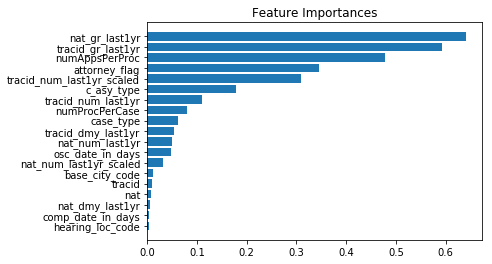

In [17]:
#simplify feature weights
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


# Test model with more time features--one feature for every year period preceding a given decision, containing grant rate for that nationality


In [18]:
file = pd.read_csv('/home/emilyboeke/merged_full_asylum_master_app_train_timecourse.csv') #version w time features
train_cases = pd.read_csv('/home/emilyboeke/train_cases_any_asylum.csv', header=None).values

train_cases = train_cases.reshape(train_cases.shape[0])
train = file[file.idncase.isin(train_cases)]
#"interaction" features (scale grant rate by number of decisions)
train['nat_num_last1yr_scaled'] = train.nat_num_last1yr*train.nat_gr_last1yr
train['tracid_num_last1yr_scaled'] = train.tracid_num_last1yr*train.tracid_gr_last1yr
train = train.drop(columns=['nat_gr_last1yr','nat_dmy_last1yr'], axis=1)#drop redundant feature

clean = Cleaning()
train_data = clean.transform(train)
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)
X_train_tr= full_pipeline.fit_transform(X_train)


/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [15]:
X_train.columns

Index(['numAppsPerProc', 'nat', 'case_type', 'c_asy_type', 'base_city_code',
       'hearing_loc_code', 'attorney_flag', 'tracid', 'numProcPerCase',
       'tracid_dmy_last1yr', 'tracid_num_last1yr', 'tracid_gr_last1yr',
       'nat_dmy_last1yr', 'nat_num_last1yr', 'nat_gr_27yr', 'nat_dmy_27yr',
       'nat_gr_26yr', 'nat_dmy_26yr', 'nat_gr_25yr', 'nat_dmy_25yr',
       'nat_gr_24yr', 'nat_dmy_24yr', 'nat_gr_23yr', 'nat_dmy_23yr',
       'nat_gr_22yr', 'nat_dmy_22yr', 'nat_gr_21yr', 'nat_dmy_21yr',
       'nat_gr_20yr', 'nat_dmy_20yr', 'nat_gr_19yr', 'nat_dmy_19yr',
       'nat_gr_18yr', 'nat_dmy_18yr', 'nat_gr_17yr', 'nat_dmy_17yr',
       'nat_gr_16yr', 'nat_dmy_16yr', 'nat_gr_15yr', 'nat_dmy_15yr',
       'nat_gr_14yr', 'nat_dmy_14yr', 'nat_gr_13yr', 'nat_dmy_13yr',
       'nat_gr_12yr', 'nat_dmy_12yr', 'nat_gr_11yr', 'nat_dmy_11yr',
       'nat_gr_10yr', 'nat_dmy_10yr', 'nat_gr_9yr', 'nat_dmy_9yr',
       'nat_gr_8yr', 'nat_dmy_8yr', 'nat_gr_7yr', 'nat_dmy_7yr', 'nat_gr_6yr',
     

In [19]:
param_grid = { 'C': [.000001,0.00001,0.0001,0.001,.01,.1,1,10,100]}
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0      13.531813         0.086669         0.702055          0.734219   1e-06   
1      24.380472         0.093889         0.727888          0.768278   1e-05   
2      36.604218         0.123704         0.736005          0.790402  0.0001   
3      76.391960         0.098498         0.721392          0.796341   0.001   
4     159.910619         0.078030         0.707913          0.799085    0.01   
5     342.516960         0.190133         0.703449          0.800195     0.1   
6     667.041077         0.201867         0.702508          0.800513       1   
7    1027.255088         0.127876         0.702358          0.800591      10   
8    1232.206852         0.120289         0.702279          0.800596     100   

          params  rank_test_score  split0_test_score  split0_train_score  \
0   {'C': 1e-06}                9           0.695602            0.744537   
1   {'C': 1e-05}                2           0.7

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/a

([<matplotlib.axis.YTick at 0x7fbbcf93cf28>,
 <a list of 98 Text yticklabel objects>)

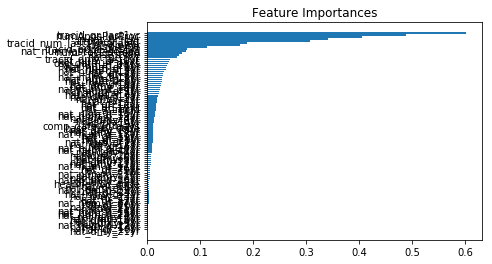

In [20]:
#simplify feature weights
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


In [21]:
[attributes[i] for i in indices]

['nat_dmy_21yr',
 'nat_gr_10yr',
 'nat_dmy_13yr',
 'nat_num_d_22yr',
 'nat_dmy_3yr',
 'nat_dmy_14yr',
 'nat_dmy_16yr',
 'nat_dmy_8yr',
 'nat_num_d_24yr',
 'nat_num_d_25yr',
 'nat_num_d_16yr',
 'nat_gr_21yr',
 'nat_dmy_25yr',
 'nat_gr_20yr',
 'nat_num_d_27yr',
 'nat_gr_22yr',
 'nat_gr_27yr',
 'nat_dmy_23yr',
 'nat_num_d_2yr',
 'nat_gr_24yr',
 'nat_num_d_23yr',
 'nat_num_d_6yr',
 'nat_gr_15yr',
 'hearing_loc_code',
 'nat_dmy_22yr',
 'nat_num_d_26yr',
 'nat_dmy_26yr',
 'nat_dmy_2yr',
 'nat_num_d_21yr',
 'nat',
 'nat_gr_25yr',
 'nat_gr_26yr',
 'nat_num_d_17yr',
 'nat_dmy_11yr',
 'nat_dmy_27yr',
 'nat_dmy_9yr',
 'nat_dmy_5yr',
 'nat_dmy_20yr',
 'nat_gr_19yr',
 'nat_dmy_7yr',
 'nat_num_last1yr',
 'nat_num_d_20yr',
 'nat_gr_5yr',
 'nat_dmy_12yr',
 'nat_num_d_1yr',
 'nat_gr_23yr',
 'nat_gr_18yr',
 'nat_gr_11yr',
 'nat_num_d_18yr',
 'nat_dmy_17yr',
 'nat_dmy_19yr',
 'base_city_code',
 'comp_date_in_days',
 'nat_gr_9yr',
 'nat_gr_14yr',
 'nat_dmy_6yr',
 'nat_dmy_24yr',
 'nat_num_d_19yr',
 'nat_n